### Planner Notebook

This notebook is my way of developing and testing the KML loading + route-finding, until it works well enough to write into a full program.


File has 89658 elements and 89530 linestrings, leaving 128 other elements (I believe only region polygons)


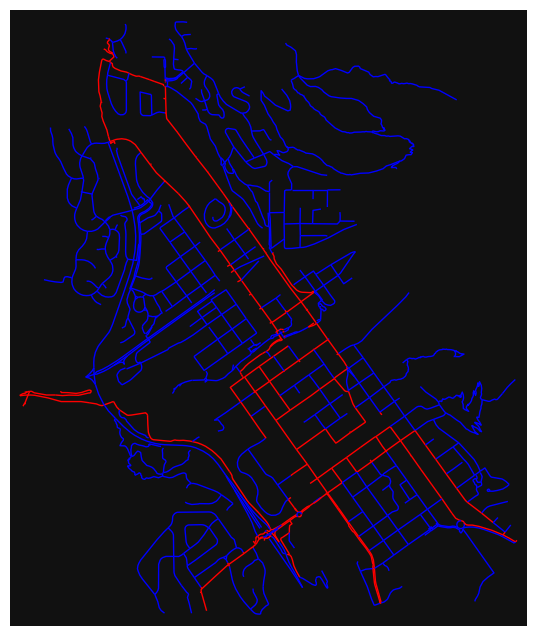

In [1]:
%run load_geo.ipynb

In [2]:
import numpy as np
import networkx as nx
from importlib import reload
import osmnx as ox
import matplotlib as mpl
import itertools
import cv2

# Inform pylint of some of the variables loaded from load_geo.ipynb
graph: nx.MultiGraph = graph
start_node: int = start_node
goal_node: int = goal_node

In [3]:
import aco_algo.ACOSettings
import aco_algo.AntColony
import aco_algo.Ant
from importlib import reload
reload(aco_algo.Ant)
reload(aco_algo.AntColony)
reload(aco_algo.ACOSettings)

settings = aco_algo.ACOSettings.ACOSettings(
    start_node=start_node,
    goal_nodes=[goal_node],
    num_ants=10,
    evaporation=0.5,
    target_length=4000,
    pheromone_weight=0.5,
    heuristic_weight=0.5,

    directional_coeff=1,
    directional_choosiness=1,
    traveled_discount=0.5,
    deadendness_coeff=10,
    finish_boost=0.5,
    gohome_boost=2,
    gohome_start_coeff=0.8,        
)


In [4]:
colony = aco_algo.AntColony.AntColony(graph, settings)
col_graph = colony.network_graph

Ant Colony Algo Init
Precomputing betweenness centrality
Updating Settings and doing some precomputation
Settings updated
Ant Colony Algo Init Done


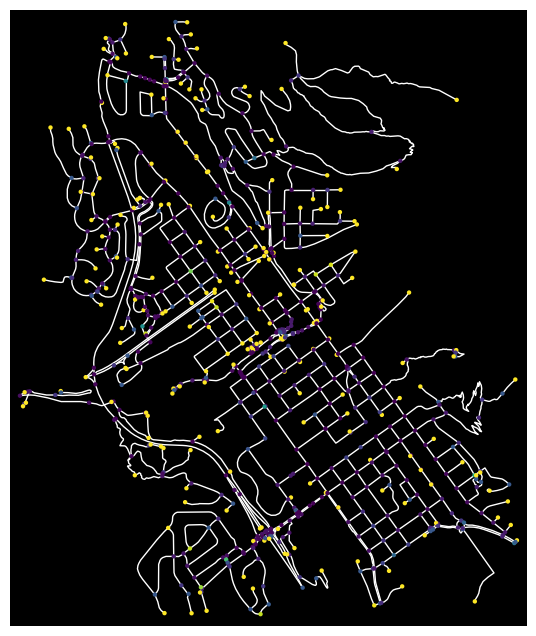

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
# Experiment with betweenness centrality
pos_dict = {key: attr["proj_pos"] for key, attr in col_graph.nodes(data=True)}
betweenness = np.array(list(nx.get_node_attributes(col_graph, "betweenness_centrality").values()))
# node_colors = [1 if math.cos(color*math.pi/2)**4 else 0 for color in node_colors]
deadendness = 1/(1+1000*betweenness)
# node_colors = very_dead_end_ratio * very_dead_end_bonus + (1-very_dead_end_ratio) * deadendness
node_colors = deadendness
ox.plot_graph(col_graph, node_color=node_colors, node_size=10, edge_color="white", bgcolor="black", show=True)
# nx.draw_networkx(col_graph, pos=pos_dict, node_color=node_colors, cmap="Reds", with_labels=False, node_size=10, width=0.1, edge_color="black")

In [6]:
from timeit import timeit
reload(aco_algo.Ant)

ant = aco_algo.Ant.Ant(col_graph, settings)
runtime = timeit(lambda: ant.desireabilities(col_graph.edges(start_node, data=True, keys=True)), number=1000)
print(f"Desireability Runtime: {runtime}")

lengths = []
for i in range(1000):
    result = ant.run()
    lengths.append(result.total_length)
    # print(f"Num Nodes: {len(route)}, length: {traveled_length}")
print(f"Average length: {sum(lengths)/len(lengths)} (min: {min(lengths)}, max: {max(lengths)}) (target: {settings.target_length})")
print(f"Stddev: {np.std(lengths)}")

Desireability Runtime: 0.06776800000079675
Average length: 3883.65384910621 (min: 221.74083149940554, max: 7874.983436377482) (target: 4000)
Stddev: 1657.222624103149


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\plot.py:309: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


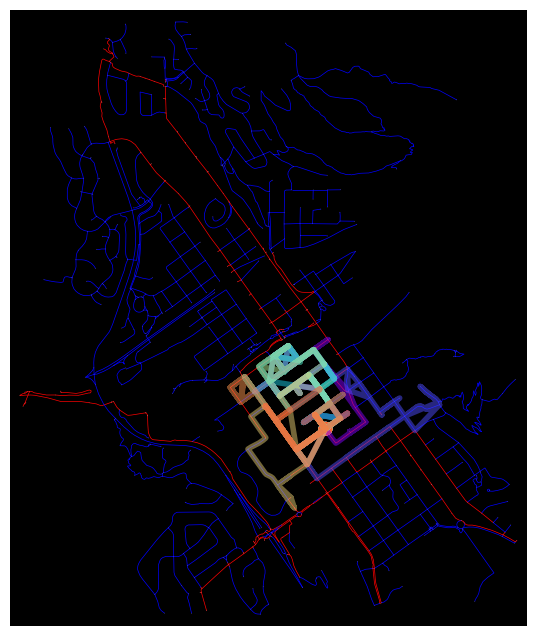

In [7]:
routes = []
n_routes = 10
cmap = mpl.colormaps["rainbow"]
for i in range(n_routes):
    result = ant.run()
    routes.append(result.route)
route_colors = [cmap(i/n_routes) for i in range(n_routes)]
traveled_colors = ['r' if (a["traveled"]) else 'b' for u, v, k, a in col_graph.edges(data=True, keys=True)]
fig, ax = ox.plot_graph_routes(col_graph, routes, node_size=0.1, edge_linewidth=0.5, edge_color=traveled_colors, bgcolor="black", show=True, route_colors=route_colors)

In [8]:
# That's a lot of repeated nodes... seems like the ants are backtracking quite a bit.
print(len(routes[0]), len(set(routes[0])))

41 25


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\plot.py:309: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


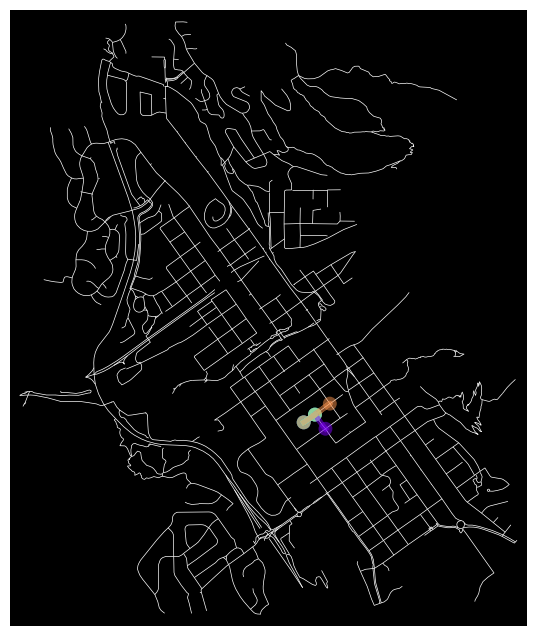

In [9]:
# The view of 10 routes above looks like there are a lot of invalid shortcuts,
# But it looks like that's a glitch with ox.plot_graph_routes.
# three-node-long chunks are sometimes drawn as triangles, which makes no sense.
route = routes[3]
segments = list(list(trio) for trio in zip(route[:-2], route[1:-1], route[2:]))[:5]
colors = [cmap(i/len(segments)) for i in range(len(segments))]
fig, ax = ox.plot_graph_routes(col_graph, segments, node_size=0.1, edge_linewidth=0.5, edge_color="white", bgcolor="black", show=True, route_colors=colors)

In [10]:
settings.num_ants = 100
colony.update_settings(settings)

# results = colony.run_iteration()
# [result[1] for result in results]

Updating Settings and doing some precomputation
Settings updated


In [11]:
# lol, if only it were so easy
# Probably some low-hanging fruit for parallelization, though...
# Copying the graph around is slow and unnecessary (its read-only, just share the memory)
# Also having all these individual ant instances.... the whole instance (graph included) is probably
#   copied to each worker process for every job.
# pool_time = timeit(colony.run_pool, number=10)
# seq_time = timeit(colony.run_sequential, number=10)
# print(f"Pool time: {pool_time}, Sequential time: {seq_time}")

Updating Settings and doing some precomputation
Settings updated


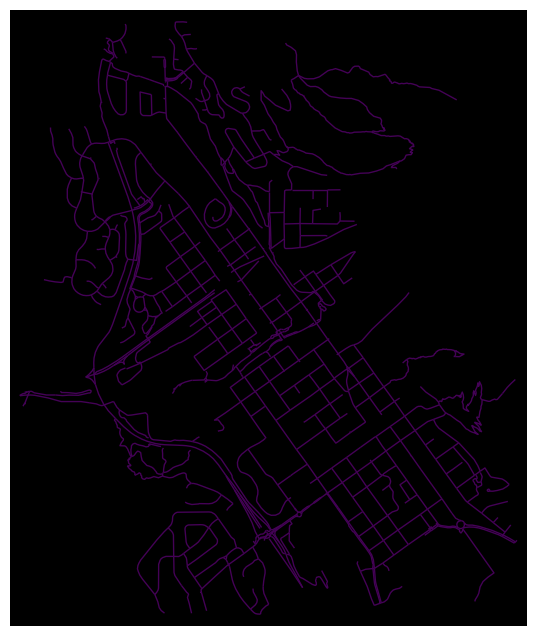

In [20]:
# Time to get vizzy
# (always the best part)
import aco_algo.InteractiveViewer
InteractiveViewer = aco_algo.InteractiveViewer.InteractiveViewer

reload(aco_algo.InteractiveViewer)
settings.num_ants = 20
settings.evaporation = 0.05
colony.update_settings(settings)

colony.reset()
viewer = InteractiveViewer(colony)
viewer.run()